In [1]:
#imports and hyperparameters

import cv2
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC  # Example weak learner
from sklearn.model_selection import train_test_split
import os
import numpy as np
from xgboost import XGBClassifier
from cv2.xfeatures2d import SIFT_create as sift_create
import pickle
import matplotlib.pyplot as plt

# Define paths and hyperparameters
data_path            = "fonts-dataset"
kmeans_sets          = 360  # Number of visual words (adjust as needed)
number_of_estimators = 50

In [2]:
# Load image paths and labels
images = []
labels = []
for folder_name in os.listdir(data_path):
  folder_path = os.path.join(data_path, folder_name)
  for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    label = folder_name  # Assuming folder name represents class label
    images.append(image_path)
    labels.append(label)

print(f"Loaded: {len(images)} images")

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)

print(f"Train Size: {len(images_train)}")
print(f"Test Size : {len(images_test)}")


Loaded: 4000 images
Train Size: 2800
Test Size : 1200


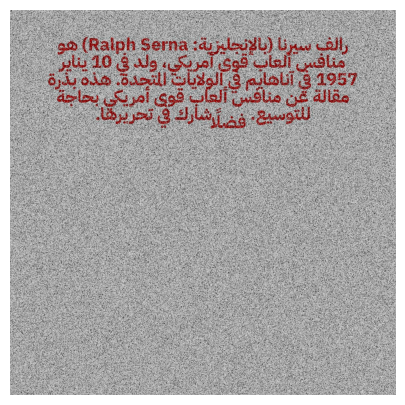

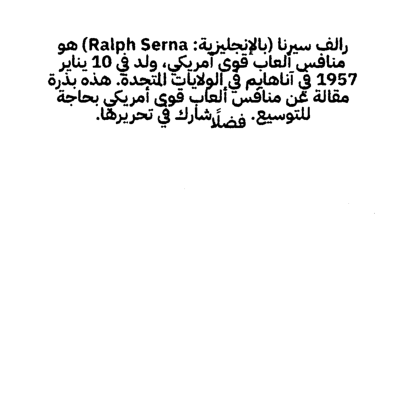

In [121]:

def image_preprocess(img):
    #img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0.1)
    img = cv2.medianBlur(img, 5)  # Kernel size can be adjusted as needed
    histogram = cv2.calcHist([img], [0], None, [256], [0, 256])
    bg_color = np.argmax(histogram)

    thresh = 0
    if bg_color == 0.0:  # If the background is brighter than a threshold, invert
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    else:
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    return thresh

def extract_surf_features(image_path):
  img = cv2.imread(image_path)
  processed_image = image_preprocess(img)
  surf = sift_create()
  keypoints, descriptors = surf.detectAndCompute(processed_image, None)
  return keypoints, descriptors

def plot(img):
    plt.figure(figsize=(10, 5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    
test_image = cv2.imread('fonts-dataset\IBM Plex Sans Arabic\829.jpeg')
preprocessed_image = image_preprocess(test_image)

plot(test_image)
plot(preprocessed_image)